In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
# ML Models
#import lightgbm as lgb
#from lightgbm import LGBMRegressor 
import xgboost as xg 
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
# Import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
accuracy_score, plot_roc_curve, roc_auc_score, recall_score, \
precision_score, f1_score, classification_report
#interpretml 
from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.perf import RegressionPerf
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
# Feature Importance 
import shap

In [2]:
train_japan = pd.read_csv('datasets/train_pisa2018_japan.csv')
test_japan = pd.read_csv('datasets/test_pisa2018_japan.csv')

In [3]:
train_japan.head(2)

CNTSTUID  EFFORT1  EFFORT2  GRADE    AGE         ISCEDL      ISCEDO  \
0  39203806.0      7.0      9.0    0.0  16.08  ISCED level 3     General   
1  39203171.0      4.0      3.0    0.0  15.67  ISCED level 3  Vocational   

   PAREDINT  HISEI  MMINS  ...  ICTOUTSIDE  WVARSTRR  GENDER      MATH  \
0      12.0  43.33  300.0  ...     -1.3048      70.0       1  530.4375   
1      12.0  51.56  250.0  ...     -1.3048      61.0       1  483.3442   

    SCIENCE      READ  TOTALSCORE  Is_MISCED_5A,6  Is_FISCED_5A,6  \
0  560.0838  556.8609  549.127400               0               0   
1  482.5687  488.0430  484.651967               0               1   

   Is_HISCED_5A,6  
0               0  
1               0  

[2 rows x 66 columns]

In [4]:
test_japan.head(2)

CNTSTUID  EFFORT1  EFFORT2  GRADE    AGE         ISCEDL      ISCEDO  \
0  39204019.0      7.0      8.0    0.0  15.67  ISCED level 3     General   
1  39201929.0      4.0     10.0    0.0  15.67  ISCED level 3  Vocational   

   PAREDINT  HISEI  MMINS  ...  ICTOUTSIDE  WVARSTRR  GENDER      MATH  \
0      12.0  76.65  200.0  ...     -0.8181      79.0       1  504.3299   
1      16.0  43.33  150.0  ...     -1.3048      64.0       1  505.6552   

   SCIENCE      READ  TOTALSCORE  Is_MISCED_5A,6  Is_FISCED_5A,6  \
0  520.477  493.3300  506.045633               0               0   
1  554.578  549.1627  536.465300               1               1   

   Is_HISCED_5A,6  
0               0  
1               1  

[2 rows x 66 columns]

In [5]:
train_japan.isnull().sum().sum(), test_japan.isnull().sum().sum()

(0, 0)

In [6]:
train_japan.set_index('CNTSTUID', inplace=True)
test_japan.set_index('CNTSTUID', inplace=True)

In [7]:
train_japan[['TOTALSCORE']].describe()

TOTALSCORE
count  4878.000000
mean    519.286964
std      84.333230
min     224.873567
25%     459.961175
50%     523.976667
75%     581.336867
max     737.421233

In [15]:
def assign_performance_level(data):
    if data <= 558:
        return '0' #lowperformance 
    else:
         return '1'  #highperformance 

In [16]:
train_japan['PISALEVEL'] = train_japan['TOTALSCORE'].apply(assign_performance_level)
test_japan['PISALEVEL'] = test_japan['TOTALSCORE'].apply(assign_performance_level)

In [17]:
train_japan['PISALEVEL'].value_counts()

0    3179
1    1699
Name: PISALEVEL, dtype: int64

In [18]:
train_japan['PISALEVEL'].value_counts(normalize=True).mul(100).round(2)

0    65.17
1    34.83
Name: PISALEVEL, dtype: float64

In [19]:
test_japan['PISALEVEL'].value_counts()

0    788
1    434
Name: PISALEVEL, dtype: int64

In [20]:
test_japan['PISALEVEL'].value_counts(normalize=True).mul(100).round(2)

0    64.48
1    35.52
Name: PISALEVEL, dtype: float64

In [21]:
#Assemble our X and y variables
X_train =train_japan[['PAREDINT', 'MMINS', 'LMINS', 'SMINS', 'ESCS', 'UNDREM', 'METASUM',
       'METASPAM', 'HOMEPOS', 'CULTPOSS', 'DISCLIMA', 'JOYREAD','SCREADCOMP', 'PISADIFF',
       'Is_FISCED_5A,6', 'Is_HISCED_5A,6', 'ISCEDL', 'ISCEDO']]
X_train = pd.get_dummies(columns=['Is_FISCED_5A,6', 'Is_HISCED_5A,6', 'ISCEDL', 'ISCEDO'], 
                         drop_first =True, data =X_train)
y_train = train_japan['PISALEVEL']

X_test =test_japan[['PAREDINT', 'MMINS', 'LMINS', 'SMINS', 'ESCS', 'UNDREM', 'METASUM',
       'METASPAM', 'HOMEPOS', 'CULTPOSS', 'DISCLIMA', 'JOYREAD','SCREADCOMP', 'PISADIFF',
        'Is_FISCED_5A,6', 'Is_HISCED_5A,6', 'ISCEDL', 'ISCEDO']]
X_test = pd.get_dummies(columns=['Is_FISCED_5A,6', 'Is_HISCED_5A,6', 'ISCEDL', 'ISCEDO'], 
                         drop_first =True, data =X_test)
y_test = test_japan['PISALEVEL']

In [22]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)

X_test_sc = scaler.transform(X_test)

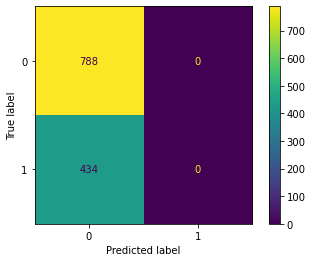

In [23]:
from sklearn.dummy import DummyClassifier
baseline_model = DummyClassifier()
baseline_model.fit(X_train_sc, y_train)
baseline_preds = baseline_model.predict(X_test_sc)
ConfusionMatrixDisplay.from_predictions(y_test, baseline_preds);

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_test, baseline_preds))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78       788
           1       0.00      0.00      0.00       434

    accuracy                           0.64      1222
   macro avg       0.32      0.50      0.39      1222
weighted avg       0.42      0.64      0.51      1222



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [25]:
logreg =LogisticRegression()


parameters = [{'penalty':['none','l2']}, 
              {'C':[1, 10, 100]}]

logreg_gr = GridSearchCV(estimator = logreg,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

logreg_gr.fit(X_train_sc, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'penalty': ['none', 'l2']}, {'C': [1, 10, 100]}],
             scoring='accuracy')

In [26]:
preds= logreg_gr.predict(X_test_sc)

In [27]:
pd.DataFrame(logreg_gr.cv_results_).sort_values('rank_test_score').head(5)[['params','mean_test_score']]

params  mean_test_score
0  {'penalty': 'none'}         0.794587
1    {'penalty': 'l2'}         0.794587
2             {'C': 1}         0.794587
3            {'C': 10}         0.794587
4           {'C': 100}         0.794587

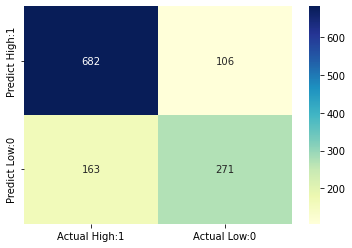

In [28]:
cm = confusion_matrix(y_test, preds)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       788
           1       0.72      0.62      0.67       434

    accuracy                           0.78      1222
   macro avg       0.76      0.74      0.75      1222
weighted avg       0.78      0.78      0.78      1222



In [30]:
logreg =LogisticRegression(random_state= 42, C= 10)
logreg.fit(X_train_sc, y_train)
preds= logreg.predict(X_test_sc)
pd.Series(logreg.coef_[0], index = X_train.columns).sort_values(ascending=False)

METASPAM             0.787555
METASUM              0.592757
JOYREAD              0.349151
PAREDINT             0.234664
SMINS                0.203721
DISCLIMA             0.198195
MMINS                0.194831
ESCS                 0.189311
LMINS                0.142035
Is_FISCED_5A,6_1     0.083941
UNDREM               0.075670
SCREADCOMP           0.070522
HOMEPOS              0.005677
CULTPOSS            -0.028688
Is_HISCED_5A,6_1    -0.051720
ISCEDO_Vocational   -0.204211
PISADIFF            -0.438758
dtype: float64

In [31]:
# coefficient dataframe
logreg_coef = pd.DataFrame(data=logreg.coef_,columns=X_train.columns).T.sort_values(by=0,ascending=False)

# Label the color the each coefficient
color = ['red' if x < 0 else 'blue' for x in logreg_coef[0]]

# Assign the color_list to new column
logreg_coef['color'] = color

logreg_coef.head()

0 color
METASPAM  0.787555  blue
METASUM   0.592757  blue
JOYREAD   0.349151  blue
PAREDINT  0.234664  blue
SMINS     0.203721  blue

In [32]:
# Select the highest values whether negative or positive
abs(logreg_coef[0]).sort_values(ascending=False)[:10].index

Index(['METASPAM', 'METASUM', 'PISADIFF', 'JOYREAD', 'PAREDINT',
       'ISCEDO_Vocational', 'SMINS', 'DISCLIMA', 'MMINS', 'ESCS'],
      dtype='object')

Text(0.5, 1.0, 'Top 10 highest coefficient')

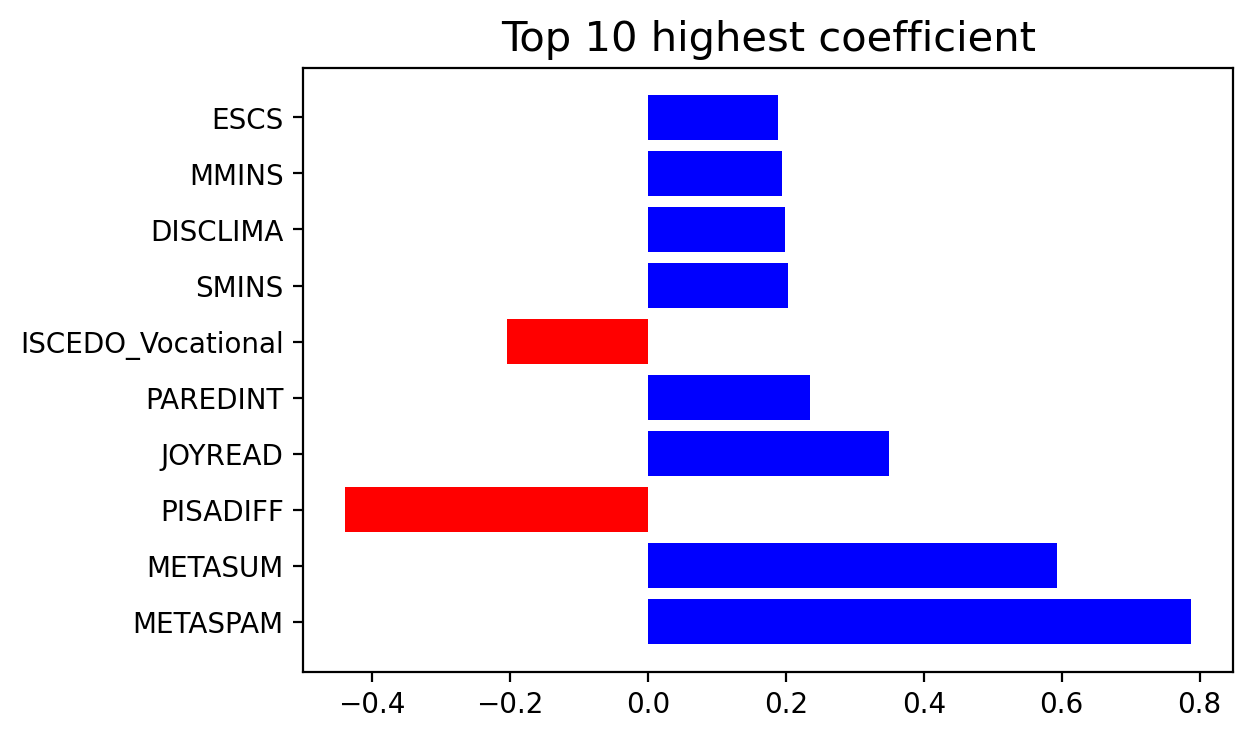

In [33]:
# Plot the coefficient of top 10 highest coefficient 
plt.figure(dpi=200)
plt.barh(logreg_coef.loc[['METASPAM', 'METASUM', 'PISADIFF', 'JOYREAD', 'PAREDINT',
       'ISCEDO_Vocational', 'SMINS', 'DISCLIMA', 'MMINS', 'ESCS']].index,logreg_coef.loc[['METASPAM', 'METASUM', 'PISADIFF', 'JOYREAD', 'PAREDINT',
       'ISCEDO_Vocational', 'SMINS', 'DISCLIMA', 'MMINS', 'ESCS']][0],color=logreg_coef.loc[['METASPAM', 'METASUM', 'PISADIFF', 'JOYREAD', 'PAREDINT',
       'ISCEDO_Vocational', 'SMINS', 'DISCLIMA', 'MMINS', 'ESCS']]['color'])
plt.title('Top 10 highest coefficient',size=15)

In [34]:
ebm = ExplainableBoostingClassifier(random_state=42, feature_names =X_train.columns)
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier(feature_names=['PAREDINT', 'MMINS', 'LMINS',
                                             'SMINS', 'ESCS', 'UNDREM',
                                             'METASUM', 'METASPAM', 'HOMEPOS',
                                             'CULTPOSS', 'DISCLIMA', 'JOYREAD',
                                             'SCREADCOMP', 'PISADIFF',
                                             'Is_FISCED_5A,6_1',
                                             'Is_HISCED_5A,6_1',
                                             'ISCEDO_Vocational',
                                             'LMINS x ESCS',
                                             'UNDREM x SCREADCOMP',
                                             'SMINS x JOYREAD', 'MMINS x SMINS',
                                             'SMINS x DISCLIMA',
                                             'HOMEPOS x JOYREAD',
                                             'SMINS x META...
                              feature_types=['continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'categorical', 'categorical',
                                             'categorical', 'interaction',
                                             'interaction', 'interaction',
                                             'interaction', 'interaction',
                                             'interaction', 'interaction',
                                             'interaction', 'interaction',
                                             'interaction'])

In [35]:
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)


In [36]:
ebm.score(X_train, y_train),ebm.score(X_test, y_test)

(0.8181631816318163, 0.7962356792144026)

In [37]:
preds_ebm = ebm.predict(X_test)

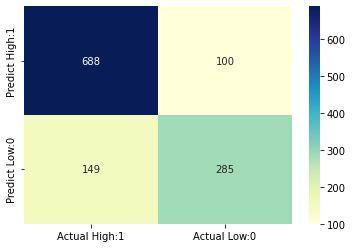

In [38]:
cm_ebm = confusion_matrix(y_test, preds_ebm)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_ebm, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [39]:
print(classification_report(y_test, preds_ebm))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       788
           1       0.74      0.66      0.70       434

    accuracy                           0.80      1222
   macro avg       0.78      0.76      0.77      1222
weighted avg       0.79      0.80      0.79      1222



In [40]:
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
param_test = {'learning_rate': [0.001,0.005,0.01,0.03],
              'interactions': [5,10,15],
              'max_interaction_bins': [10,15,20],
              'max_rounds': [5000,10000,15000,20000],
              'min_samples_leaf': [2,3,5],
              'max_leaves': [3,5,10]}
n_HP_points_to_test=10
ebm_clf =ExplainableBoostingClassifier(random_state=42, feature_names =X_train.columns, n_jobs=-1)
ebm_gs = RandomizedSearchCV(
    estimator=ebm_clf,
    param_distributions=param_test,
    n_iter=n_HP_points_to_test,
    scoring="roc_auc",
    cv=3,
    refit=True,
    random_state=314,
    verbose=False,
)


In [41]:
ebm_gs.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=ExplainableBoostingClassifier(feature_names=Index(['PAREDINT', 'MMINS', 'LMINS', 'SMINS', 'ESCS', 'UNDREM', 'METASUM',
       'METASPAM', 'HOMEPOS', 'CULTPOSS', 'DISCLIMA', 'JOYREAD', 'SCREADCOMP',
       'PISADIFF', 'Is_FISCED_5A,6_1', 'Is_HISCED_5A,6_1',
       'ISCEDO_Vocational'],
      dtype='object'),
                                                           n_jobs=-1),
                   param_distributions={'interactions': [5, 10, 15],
                                        'learning_rate': [0.001, 0.005, 0.01,
                                                          0.03],
                                        'max_interaction_bins': [10, 15, 20],
                                        'max_leaves': [3, 5, 10],
                                        'max_rounds': [5000, 10000, 15000,
                                                       20000],
                                        'min_samples_leaf': [2, 3, 5]},
                   random_state=314, scoring='roc_auc', verbose=False)

In [42]:
#y_train = le.fit_transform(y_train)
#y_test = le.fit_transform(y_test)

In [43]:
ebm_gs.best_params_

{'min_samples_leaf': 3,
 'max_rounds': 20000,
 'max_leaves': 5,
 'max_interaction_bins': 20,
 'learning_rate': 0.005,
 'interactions': 15}

In [44]:
preds_ebm_gs = ebm_gs.predict(X_test)

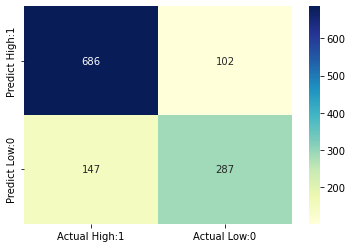

In [45]:
cm_ebm_gs = confusion_matrix(y_test, preds_ebm_gs)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_ebm_gs, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [46]:
print(classification_report(y_test, preds_ebm_gs))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       788
           1       0.74      0.66      0.70       434

    accuracy                           0.80      1222
   macro avg       0.78      0.77      0.77      1222
weighted avg       0.79      0.80      0.79      1222



In [47]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# fit the model to the training set

rfc.fit(X_train, y_train)

# Predict on the test set results

preds_rfc = rfc.predict(X_test)
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. 
      format(accuracy_score(y_test, preds)))

Model accuracy score with 100 decision-trees : 0.7799


In [48]:
#Find important features with Random Forest model 

In [49]:
# view the feature scores

feature_scores = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

METASPAM             0.111224
METASUM              0.109013
JOYREAD              0.101344
ESCS                 0.086363
SMINS                0.073926
HOMEPOS              0.070998
MMINS                0.070098
PISADIFF             0.064478
CULTPOSS             0.058253
DISCLIMA             0.057721
SCREADCOMP           0.055343
LMINS                0.048185
UNDREM               0.041866
PAREDINT             0.018280
ISCEDO_Vocational    0.012718
Is_FISCED_5A,6_1     0.010549
Is_HISCED_5A,6_1     0.009641
dtype: float64

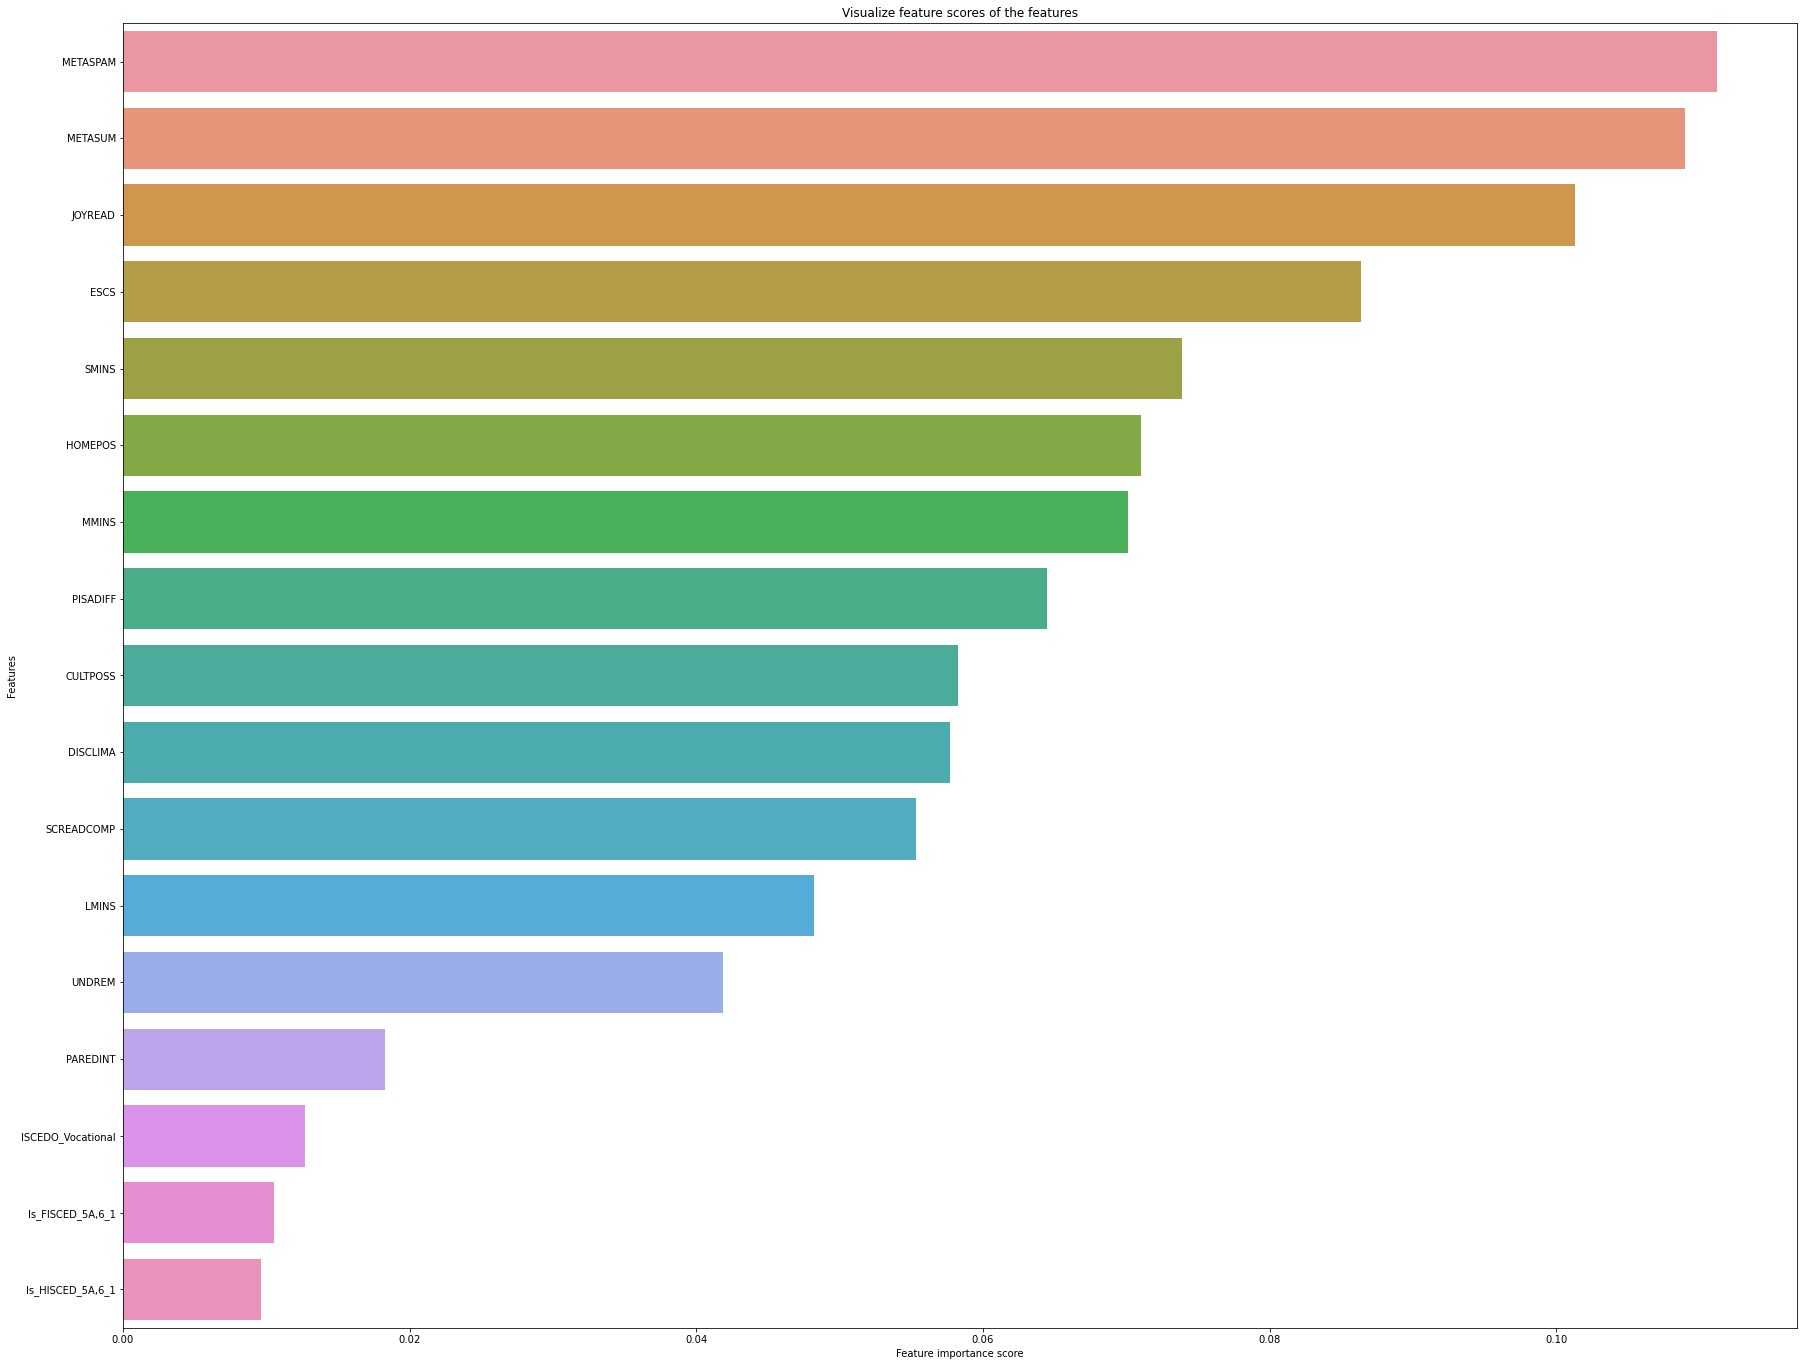

In [51]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=train_japan)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

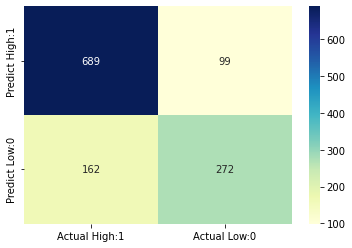

In [52]:
cm_rfc = confusion_matrix(y_test, preds_rfc)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_rfc, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [53]:
print(classification_report(y_test, preds_rfc))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       788
           1       0.73      0.63      0.68       434

    accuracy                           0.79      1222
   macro avg       0.77      0.75      0.76      1222
weighted avg       0.78      0.79      0.78      1222



In [54]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [55]:
xgb = XGBClassifier(n_estimators = 200, learning_rate = 0.5, max_depth = 4)
xgb.fit(X_train_sc, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [56]:
preds_xgb = xgb.predict(X_test_sc)

In [57]:
# view the feature scores

feature_scores = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

METASPAM             0.234135
Is_HISCED_5A,6_1     0.165375
METASUM              0.088956
MMINS                0.061035
SMINS                0.055032
PISADIFF             0.052906
ISCEDO_Vocational    0.047111
JOYREAD              0.035552
LMINS                0.035416
SCREADCOMP           0.032261
ESCS                 0.030417
Is_FISCED_5A,6_1     0.030219
PAREDINT             0.028661
DISCLIMA             0.027401
HOMEPOS              0.026100
CULTPOSS             0.024988
UNDREM               0.024436
dtype: float32

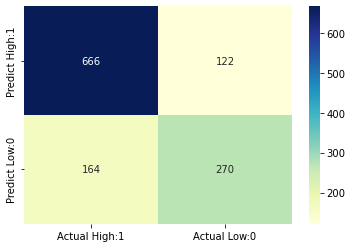

In [58]:
cm_xgb = confusion_matrix(y_test, preds_xgb)
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm_xgb, columns=['Actual High:1', 'Actual Low:0'], 
                                 index=['Predict High:1', 'Predict Low:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu');

In [59]:
print(classification_report(y_test, preds_xgb))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       788
           1       0.69      0.62      0.65       434

    accuracy                           0.77      1222
   macro avg       0.75      0.73      0.74      1222
weighted avg       0.76      0.77      0.76      1222



In [60]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train_sc)

C:\Users\science01\Anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



In [61]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:],  pd.DataFrame(X_test, columns =X_test.columns).iloc[0,:])

In [62]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:],  pd.DataFrame(X_test, columns =X_test.columns).iloc[:1000,:])

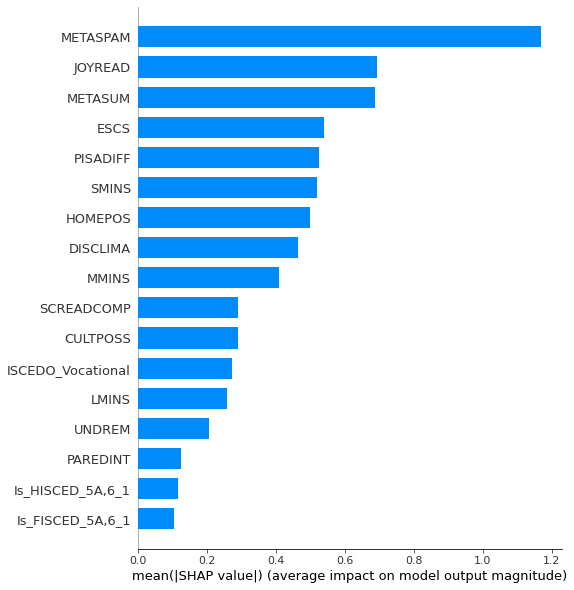

In [63]:
shap.summary_plot(shap_values, X_train_sc, plot_type="bar", feature_names= X_train.columns)

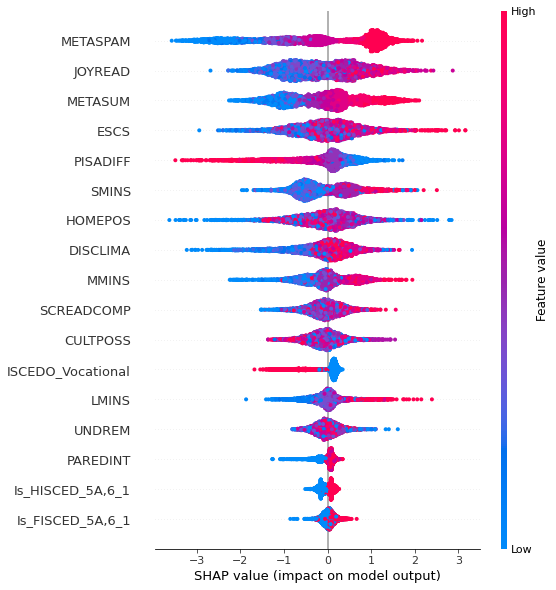

In [64]:
shap.summary_plot(shap_values, X_train)

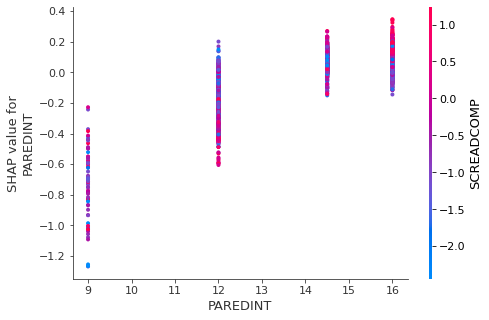

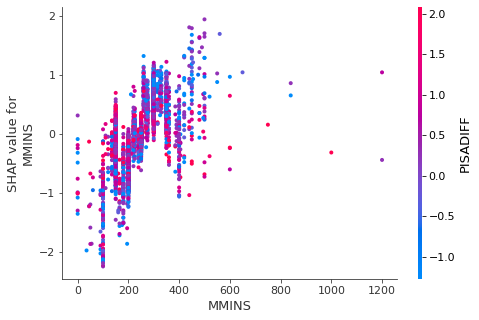

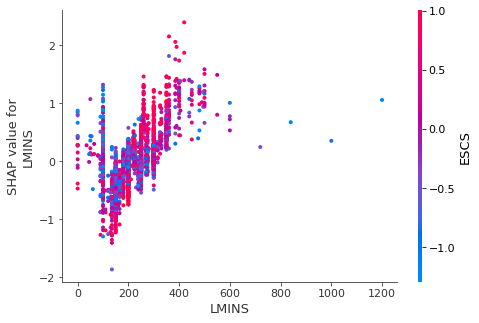

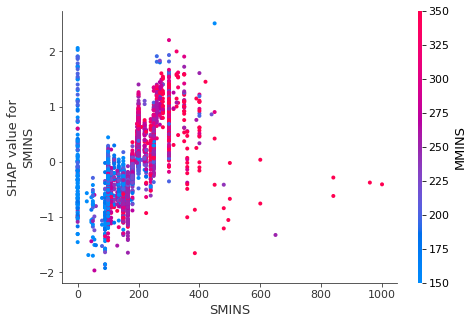

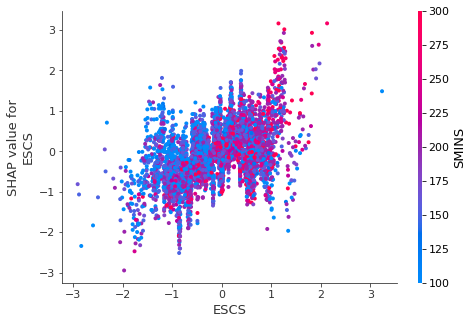

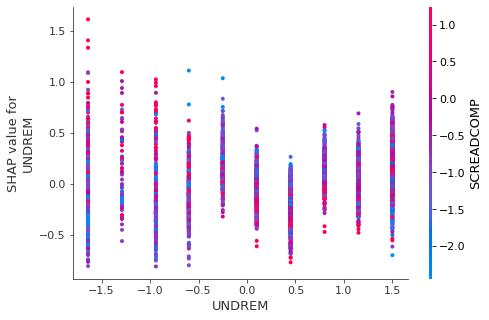

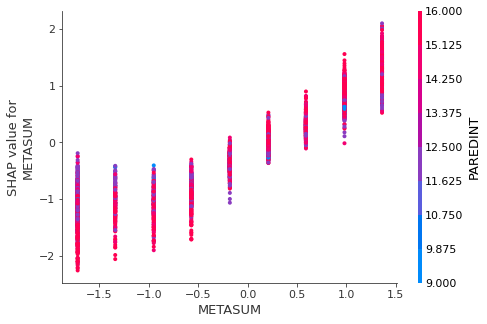

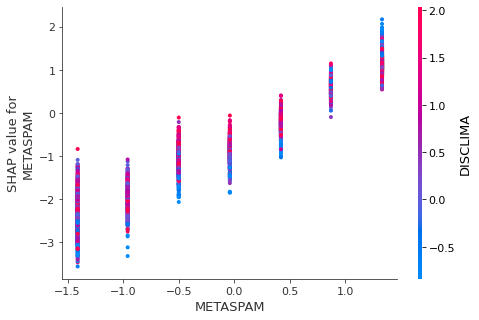

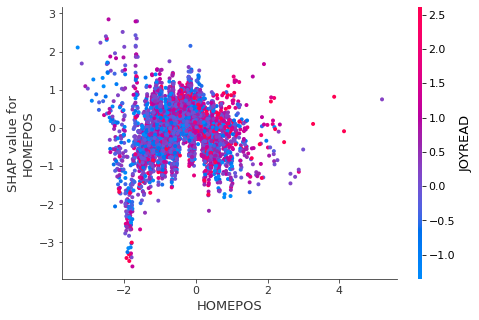

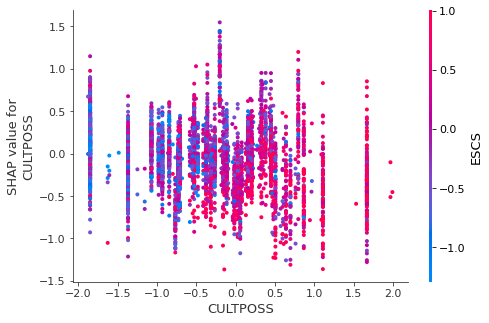

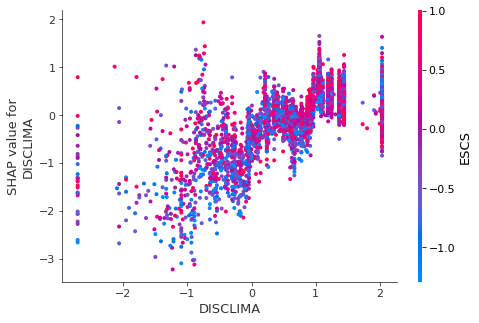

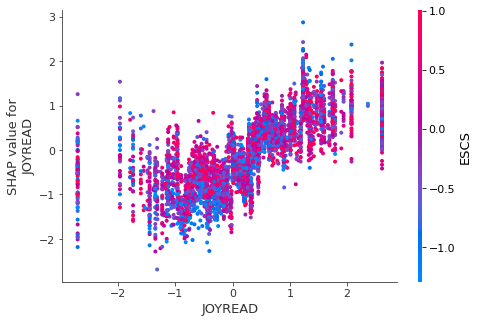

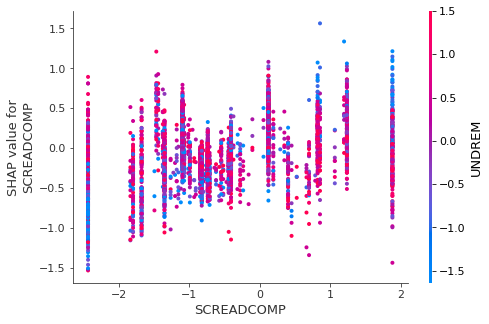

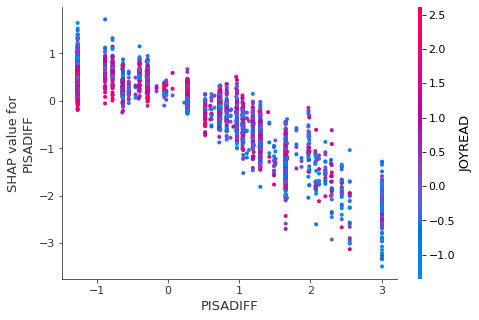

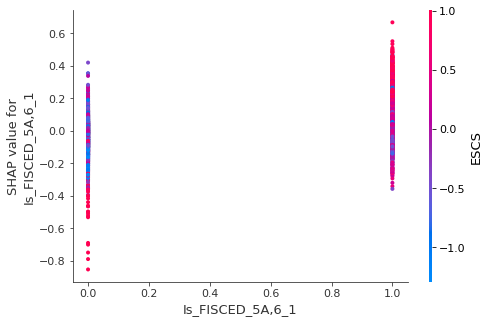

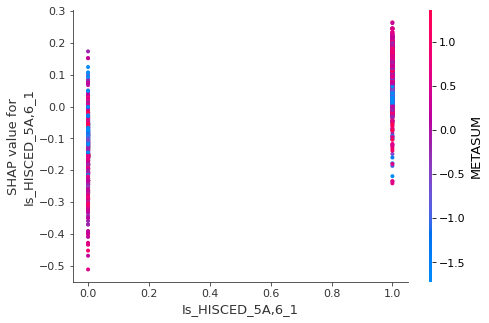

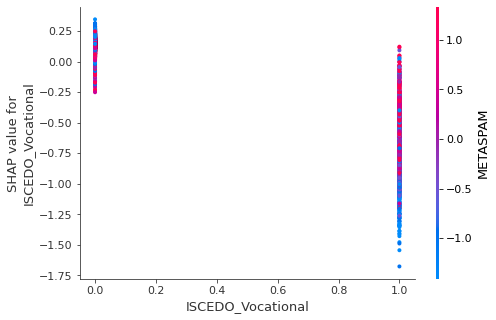

In [65]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)